<a href="https://colab.research.google.com/github/HannaKi/Deep_Learning_in_LangTech_course/blob/master/bert_sequence_labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence labeling with BERT

This notebook briefly demonstrates fine-tuning a pretrained BERT model to a sequence labeling task.

You probably want to run this notebook with GPU acceleration, as fine-tuning BERT on CPU can be fairly slow even with a comparatively small dataset.

## Configuration

The following variables configure a few aspects of the data, model, and training process. To adapt this example to a different dataset, you'll probably want to change these to match.

Note in particular that we're limiting the number of examples and the maximum sequence length to make training faster. 

When running on GPU, it's also necessary to make sure that the input length and batch size are not so large as to cause a batch to exceed GPU memory. If you're getting a message like `Resource exhausted: OOM when allocating tensor`, try smaller numbers for these.

In [0]:
# Maximum number of examples to read
MAX_EXAMPLES = 2000

# Maximum length of input sequence in tokens
INPUT_LENGTH = 25

# Number of epochs to train for
EPOCHS = 3

# Optimizer learning rate
LEARNING_RATE = 0.00002

# Training batch size
BATCH_SIZE = 8

## Package setup

We'll use [keras-bert](https://github.com/CyberZHG/keras-bert). Make sure the package is installed. (`pip` is the Python [package installer](https://pip.pypa.io/en/stable/))

In [2]:
!pip3 install keras-bert

  Created wheel for keras-bert: filename=keras_bert-0.81.0-cp36-none-any.whl size=37913 sha256=faa3afea3effd497b671abd1de3a8190c3abf53bc1d5cc71a9c5255a94644ccf
  Stored in directory: /root/.cache/pip/wheels/bd/27/da/ffc2d573aa48b87440ec4f98bc7c992e3a2d899edb2d22ef9e
  Created wheel for keras-transformer: filename=keras_transformer-0.33.0-cp36-none-any.whl size=13260 sha256=deb55844f35d51b887d6a5db31f762750ded94dcee04ae9c8ad1b33f333a6d5a
  Stored in directory: /root/.cache/pip/wheels/26/98/13/a28402939e1d48edd8704e6b02f223795af4a706815f4bf6d8
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7554 sha256=2c3f8f697553410d6b97013934272577f8310a9d61615e85deaed2bd8ddab9eb
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-cp36-none-any.whl size=15371 sha256=5ea1b2cdb88e9733698b5c75bb0ce0065524d8e565c9caafceda60e51058d679
  Stor

## Tensorflow configuration

We'll need set an environment variable for keras-bert to use `tensorflow.python.keras`. (This is a technical detail that is not related to the model.)

In [0]:
import os


os.environ['TF_KERAS'] = '1'    # Required to use tensorflow.python.keras with keras-bert

## Download dataset

We'll use part-of-speech tags from a recent [Universal Dependencies]() version of the English [EWT corpus](https://nlp.stanford.edu/pubs/Gold_LREC14.pdf).

Download the training and development subsets of the corpus data.

In [4]:
# Give -nc (--no-clobber) argument so that the file isn't downloaded multiple times 
!wget -nc https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-train.conllu
!wget -nc https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-dev.conllu

--2020-04-28 08:02:33--  https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-train.conllu
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu [following]
--2020-04-28 08:02:34--  https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13303560 (13M) [text/plain]
Saving to: ‘en_ewt-ud-train.conllu’

en_ewt-ud-train.con 100%[===================>]  12.69M  29.4MB/s    in 0.4s    

2020-04-28 08:02:35 (29.4 MB/s) - ‘en_ewt-ud-

## Load data

The corpus is in [CoNLL-U](https://universaldependencies.org/format) format. We won't get into the details of the format here, as it's enough to know the following:

* Lines beginning with `#` are comments and can be ignored
* Empty lines delimit sentences
* Remaining lines contain information on words, with fields separated by a tab
* On lines where the first field is an integer (word index), the second field contains the word surface form, and the fourth the part-of-speech tag

We'll grab the wordforms and POS tags and keep them organized by sentences.

Note that before (potentially) truncating the examples to `MAX_EXAMPLES` we'll shuffle the list of sentences, but keep the words in their original order.

In [5]:
import random


random.seed(1234)    # This makes random.shuffle() produce the same order every time



def load_conllu_tags(fn):
    sentences = []
    with open(fn) as f:
        current = []
        for line in f:
            line = line.rstrip('\n')
            if line.startswith('#'):
                continue    # Comment line, skip
            if line == '' or line.isspace():
                # Empty line, sentence boundary
                sentences.append(current)
                current = []
                continue
            fields = line.split('\t')
            if not fields[0].isdigit():
                continue    # Not a regular word, skip
            word, tag = fields[1], fields[3]
            current.append((word, tag))
            
    random.shuffle(sentences)
    if len(sentences) > MAX_EXAMPLES:
        print('Note: truncating examples in {} from {} to {}'.format(fn, len(sentences), MAX_EXAMPLES))
        sentences = sentences[:MAX_EXAMPLES]

    return sentences


train_sentences = load_conllu_tags('en_ewt-ud-train.conllu')
dev_sentences = load_conllu_tags('en_ewt-ud-dev.conllu')


# Have a look at the data
print('\nExample sentence:')
for word, tag in train_sentences[0]:
    print('{}\t{}'.format(word, tag))

Note: truncating examples in en_ewt-ud-train.conllu from 12543 to 2000
Note: truncating examples in en_ewt-ud-dev.conllu from 2002 to 2000

Example sentence:
They	PRON
had	VERB
a	DET
great	ADJ
selection	NOUN
of	ADP
colors	NOUN
to	PART
choose	VERB
from	ADP
and	CCONJ
their	PRON
seats	NOUN
are	AUX
super	ADV
comfty	ADJ
.	PUNCT


## Download pretrained BERT model

As training BERT from scratch generally takes days, we'll here load a pretrained model and fine-tune it for our task. URLs to download pre-trained models made available by Google are found at https://github.com/google-research/bert .

`cased_L-12_H-768_A-12` is a case-sensitive BERT "base" model for English: 12 layers, 768-dimensional hidden state, and 12 "heads" for multi-head attention.

In [6]:
# Give -nc (--no-clobber) argument so that the file isn't downloaded multiple times 
!wget -nc https://storage.googleapis.com/bert_models/2018_10_18/cased_L-12_H-768_A-12.zip

--2020-04-28 08:06:28--  https://storage.googleapis.com/bert_models/2018_10_18/cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 404261442 (386M) [application/zip]
Saving to: ‘cased_L-12_H-768_A-12.zip’

cased_L-12_H-768_A- 100%[===================>] 385.53M  70.0MB/s    in 5.9s    

2020-04-28 08:06:34 (65.1 MB/s) - ‘cased_L-12_H-768_A-12.zip’ saved [404261442/404261442]



Unpack the downloaded file:

In [7]:
# Give -n argument so that existing files aren't overwritten 
!unzip -n cased_L-12_H-768_A-12.zip

Archive:  cased_L-12_H-768_A-12.zip
   creating: cased_L-12_H-768_A-12/
  inflating: cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: cased_L-12_H-768_A-12/vocab.txt  
  inflating: cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: cased_L-12_H-768_A-12/bert_config.json  


There are three key parts to the package contents:

* `vocab.txt`: plain text file listing vocabulary items
* `bert_config.json`: model configuration in JSON format
* `bert_model.ckpt.*`: model checkpoint data with pre-trained weights in [Tensorflow checkpoint format](https://www.tensorflow.org/guide/checkpoint)

Take note of the path to these (you'll need to change this if you pick a different model)

In [0]:
bert_vocab_path = 'cased_L-12_H-768_A-12/vocab.txt'
bert_config_path = 'cased_L-12_H-768_A-12/bert_config.json'
bert_checkpoint_path = 'cased_L-12_H-768_A-12/bert_model.ckpt'    # suffixes not required

Also take note if the model we downloaded was a case-sensitive (cased) or not. (This must match the model.)

In [0]:
model_is_cased = True

## Load BERT vocabulary

This is just a plain text file with one vocabulary item per line.

In [10]:
vocab = []
with open(bert_vocab_path) as f:
    for i, line in enumerate(f):
        vocab.append(line.rstrip('\n'))    # rstrip to remove newline characters


# Print a list with every 500th vocabulary item
print(vocab[0::500])

['[PAD]', 'щ', '吉', 'told', 'space', 'operations', 'proposed', 'Oxford', 'showing', 'domestic', 'mountains', 'commission', 'voices', 'associate', 'hills', 'Guide', 'relaxed', 'Page', 'Heights', 'singers', 'Interior', 'considers', 'facilitate', 'shouting', '1826', 'constitute', 'alter', 'clip', 'Into', 'Memory', 'ballad', 'Owens', 'Langdon', 'aquatic', 'stereo', 'Cass', 'Shock', '195', '##tec', '##sonic', 'attested', '##rdes', '1840s', '##90', 'Guys', '##rien', 'Munro', 'Ursula', 'mesh', 'diplomacy', 'Newmarket', '##oughs', 'synthesizers', 'Drugs', 'monstrous', '##ynamic', 'troll', '##ٹ']


## Load BERT configuration

The configuration is just a JSON file, so we can read it in with `json.load` from the python `json` library.

We won't actually need to use these configuration details directly (keras-bert takes care of them for us), so this is just here to show what information is contained in the config file.

In [11]:
import json

from pprint import pprint    # pretty-printer for output


with open(bert_config_path) as f:
    config = json.load(f)


# Print configuration contents
pprint(config)

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 28996}


## Create BERT tokenizer

To create the tokenizer, we'll need a mapping from vocabulary items to their corresponding integer indices. We do this conventionally using `enumerate`.

In [12]:
# Create mapping from vocabulary items to their indices in the vocabulary
token_dict = { v: i for i, v in enumerate(vocab) }


# Print some random examples of the mapping
pprint(dict(random.choices(list(token_dict.items()), k=10)))

{'##umi': 14088,
 'Helsinki': 12471,
 'assassinated': 17493,
 'brackets': 22019,
 'drowned': 14100,
 'educational': 4339,
 'firmly': 7487,
 'instincts': 17477,
 'internet': 7210,
 'nuts': 13937}


We'll use the keras-bert `Tokenizer` for BERT tokenization. The implementation supports

* (Optional) lowercasing: `Hello` → `hello`
* Basic tokenization: `Hello!` → `Hello` `!`, `multi-part` → `multi` `-` `part`
* Wordpiece tokenization: `comprehensively` → `comprehensive` `##ly`
* Adding special tokens: `Sentence`  → `[CLS]` `Sentence` `[SEP]`
* Mapping to integer indices
* Generating segment sequence
* (Optional) padding and truncation to length

In the following example, notice how words not in the dictionary are broken up into subwords (with continuation parts starting with `##`) and how unknown _characters_ are mapped to a special unknown word token `[UNK]`.

In [13]:
from keras_bert import Tokenizer


tokenizer = Tokenizer(token_dict, cased=model_is_cased)


# Let's test that out
for s in ['Hello BERT!', 'Unknown: 你']:
    print('Original string:', s)
    print('Tokenized:', tokenizer.tokenize(s))
    indices, segments = tokenizer.encode(s, max_len=20)    # max_len for padding and truncation
    print('Encoded:', indices)
    print('Segments:', segments)
    print('Decoded:', ' '.join(tokenizer.decode(indices)))
    print()

Original string: Hello BERT!
Tokenized: ['[CLS]', 'Hello', 'B', '##ER', '##T', '!', '[SEP]']
Encoded: [101, 8667, 139, 9637, 1942, 106, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Segments: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: Hello B ##ER ##T !

Original string: Unknown: 你
Tokenized: ['[CLS]', 'Unknown', ':', '你', '[SEP]']
Encoded: [101, 16285, 131, 100, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Segments: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: Unknown : [UNK]



## Vectorize data

We'll use keras-bert `Tokenizer` to tokenize and vectorize words. For vectorizing labels (tags), we'll create a simple mapping ourselves.

We'll also add a special placeholder label `NO_LABEL` for padding and continuation wordpieces (more on that below).

In [14]:
# This is our special placeholder label value
NO_LABEL = 'NONE'


# This just flattens out tags from the sentences list-of-lists
train_tags = [tag for sentence in train_sentences for word, tag in sentence]
# Use set() to get the unique tags and add our special label to the list
unique_tags = [NO_LABEL] + sorted(set(train_tags))

# Create mappings from tags to integer values and back
tag_to_int = { t: i for i, t in enumerate(unique_tags) }
int_to_tag = { i: t for t, i in tag_to_int.items() }

# Take note of how many unique labels (tags) there are in the data
num_labels = len(unique_tags)


# Let's see what we got
print('Number of unique labels:', num_labels)
print('Tags:', unique_tags)
print('Mapping:', tag_to_int)
print('Inverted:', int_to_tag)

Number of unique labels: 18
Tags: ['NONE', 'ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']
Mapping: {'NONE': 0, 'ADJ': 1, 'ADP': 2, 'ADV': 3, 'AUX': 4, 'CCONJ': 5, 'DET': 6, 'INTJ': 7, 'NOUN': 8, 'NUM': 9, 'PART': 10, 'PRON': 11, 'PROPN': 12, 'PUNCT': 13, 'SCONJ': 14, 'SYM': 15, 'VERB': 16, 'X': 17}
Inverted: {0: 'NONE', 1: 'ADJ', 2: 'ADP', 3: 'ADV', 4: 'AUX', 5: 'CCONJ', 6: 'DET', 7: 'INTJ', 8: 'NOUN', 9: 'NUM', 10: 'PART', 11: 'PRON', 12: 'PROPN', 13: 'PUNCT', 14: 'SCONJ', 15: 'SYM', 16: 'VERB', 17: 'X'}


The source data has one tag for each (syntactic) word. If we were training a model from scratch, we could define the tokenization to match the data so that we would get a simply one-to-one mapping between input words and output tags. However, as we're using a pre-trained model, we need to work with the existing tokenization, which may split up some of the input words into multiple parts.

For example, if the data contains the word, tag pair `(complicatedly, ADV)` and the tokenizer splits up the word into `complicated` `##ly`, we have two tokens (`complicated` and `##ly`) but just one tag (`ADV`). There are a number of ways we could resolve this. Here, we will assign the original tag to the first wordpiece and the placeholder tag we introduced earlier to any subsequent pieces, so e.g. `(complicatedly, ADV)` would map to `(complicated, ADV)`, `(##ly, NONE)`.

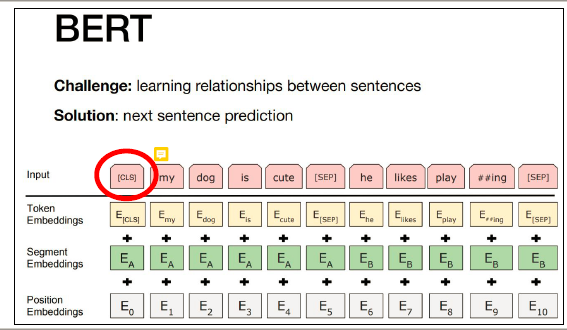

In [15]:
import numpy as np


def tokenize_word(word):
    # keras-bert tokenizer wraps its inputs with the special BERT tokens
    # [CLS] and [SEP]. To tokenize individual words, we remove these.
    wrapped = tokenizer.tokenize(word)
    return wrapped[1:-1]    # remove [CLS] at the first and [SEP] at the last position


def tokenize_sentence(sentence):
    tokenized = []
    for word, tag in sentence:
        tokens = tokenize_word(word) # tokenize words
        # Original tag for first wordpiece, fill in placeholder tags for
        # any continuation pieces.
        tags = [tag] + [NO_LABEL] * (len(tokens)-1)
        tokenized.append((tokens, tags)) 
    return tokenized


def tokenize_sentences(sentences):
    return [tokenize_sentence(s) for s in sentences]


tokenized_train = tokenize_sentences(train_sentences)
tokenized_dev = tokenize_sentences(dev_sentences)


# Let's look at an example sentence after tokenization
for tokens, tags in tokenized_train[0]:
    print(tokens, tags)

['They'] ['PRON']
['had'] ['VERB']
['a'] ['DET']
['great'] ['ADJ']
['selection'] ['NOUN']
['of'] ['ADP']
['colors'] ['NOUN']
['to'] ['PART']
['choose'] ['VERB']
['from'] ['ADP']
['and'] ['CCONJ']
['their'] ['PRON']
['seats'] ['NOUN']
['are'] ['AUX']
['super'] ['ADV']
['com', '##fty'] ['ADJ', 'NONE']
['.'] ['PUNCT']


To vectorize a tokenized sentence and its labels, we'll truncate to target length, add the special BERT tokens `[CLS]` and `[SEP]` (and corresponding placeholder labels), pad to length with the special `[PAD]` token if necessary, and map both tokens and tags to integer indices.

In [17]:
from tensorflow.keras.utils import to_categorical


def vectorize_tokenized(tokenized, length=INPUT_LENGTH):
    # Flatten lists-of-lists of tokens and tags
    token_sequence, tag_sequence = [], []
    for tokens, tags in tokenized:
        token_sequence.extend(tokens)
        tag_sequence.extend(tags)

    # Truncation and padding using length-2 to leave space for
    # wrapping with the special [CLS] and [SEP] tokens
    if len(token_sequence) > length-2:
        token_sequence = token_sequence[:length-2]
        tag_sequence = tag_sequence[:length-2]

    # Wrap with [CLS] and [SEP], adding corresponding placeholder labels
    token_sequence = ['[CLS]'] + token_sequence + ['[SEP]']
    tag_sequence = [NO_LABEL] + tag_sequence + [NO_LABEL]

    while len(token_sequence) < length:
        token_sequence.append('[PAD]')
        tag_sequence.append(NO_LABEL)
    
    # Use keras-bert tokenizer and previously created label mapping
    token_ids = tokenizer._convert_tokens_to_ids(token_sequence)
    tag_ids = [tag_to_int[tag] for tag in tag_sequence]
    
    # Also create all-zeros segment IDs for BERT
    segment_ids = [0] * INPUT_LENGTH

    return token_ids, segment_ids, tag_ids


def vectorize_dataset(tokenized_data, length=INPUT_LENGTH):
    # Create separate lists of token ID, segment ID, and tag ID lists,
    # each of the inner lists representing one sentence.
    token_ids_list, segment_ids_list, tag_ids_list = [], [], []
    for tokenized in tokenized_data:
        token_ids, segment_ids, tag_ids = vectorize_tokenized(tokenized, length=length)
        token_ids_list.append(token_ids)
        segment_ids_list.append(segment_ids)
        tag_ids_list.append(tag_ids)

    # Return as numpy arrays. Input (X) consists of the token and
    # segment IDs, output (Y) of the tag ids. We'll use a one-hot
    # representation for the output.
    X = [np.array(token_ids_list), np.array(segment_ids_list)]
    Y = to_categorical(np.array(tag_ids_list))

    return X, Y
    

train_X, train_Y = vectorize_dataset(tokenized_train)
dev_X, dev_Y = vectorize_dataset(tokenized_dev)


# Let's have a bit of a look at that
print('train_X[0].shape:', train_X[0].shape)
print('train_X[1].shape:', train_X[1].shape)
print('train_Y[0].shape:', train_Y[0].shape)
print()
print('train_X[0][0] (first sentence token IDs):')
print(train_X[0][0])
print()
print('train_X[1][0] (first sentence segment IDs):')
print(train_X[1][0])
print()
print('train_Y[0][0] (first sentence tag IDs):')
print(train_Y[0])
print()
print('decoded train_X[0][0] (first sentence tokens):')
print(' '.join([tokenizer._token_dict_inv[t] for t in train_X[0][0]]))
print()
print('decoded train_Y[0] (first sentence tags):')
print(' '.join([int_to_tag[t.argmax()] for t in train_Y[0]]))

train_X[0].shape: (2000, 25)
train_X[1].shape: (2000, 25)
train_Y[0].shape: (25, 18)

train_X[0][0] (first sentence token IDs):
[  101  1220  1125   170  1632  4557  1104  5769  1106  4835  1121  1105
  1147  3474  1132  7688  3254 27944   119   102     0     0     0     0
     0]

train_X[1][0] (first sentence segment IDs):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

train_Y[0][0] (first sentence tag IDs):
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1.

## Load pretrained BERT model

We'll use the keras-bert function `load_trained_model_from_checkpoint` to load the model from the checkpoint we downloaded earlier.

Explanation for a few parameters from keras-bert documentation:

* `training`: If `training`, the whole model will be returned. Otherwise, the MLM [masked language modeling] and NSP [next sentence prediction] parts will be ignored.
* `trainable`: Whether the model is trainable. The default value is the same with `training`.

We don't need the masked language modeling or next sentence prediction parts (these are primarily for pretraining), so we'll use `training=False` but `trainable=True`.

In [0]:
from keras_bert import load_trained_model_from_checkpoint


pretrained_model = load_trained_model_from_checkpoint(
    config_file = bert_config_path,
    checkpoint_file = bert_checkpoint_path,
    training = False,
    trainable = True,
    seq_len = INPUT_LENGTH
)

Let's have a bit of a look at that model

In [19]:
# This is a keras model, so we can figure out what inputs it takes like so:
pretrained_model.inputs

[<tf.Tensor 'Input-Token:0' shape=(None, 25) dtype=float32>,
 <tf.Tensor 'Input-Segment:0' shape=(None, 25) dtype=float32>]

In [20]:
# And similarly for outputs:
pretrained_model.outputs

[<tf.Tensor 'Encoder-12-FeedForward-Norm/Identity:0' shape=(None, 25, 768) dtype=float32>]

So, the model takes `Input-Token` and `Input-Segment` inputs, both of dimension (batch-size, input-length), and produces a single output tensor of dimension (batch-size, input-length, hidden-dim). This is just what we want for sequence labeling.

In [21]:
pretrained_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 25)]         0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 25)]         0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 25, 768), (2 22268928    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 25, 768)      1536        Input-Segment[0][0]              
____________________________________________________________________________________________

This is a regular Keras model. In Keras, models behave very much like layers, so we're able to wrap this in our own model.

## Build sequence labeling model

We'll make a _very_ simple model for sequence labeling: just attach a time-distributed dense layer with softmax activation to the output, and connect the model inputs to the BERT model inputs.

In [23]:
# model.outputs is a list, here with a single item. We'll
# add our output layer on top of that.
bert_out = pretrained_model.outputs[0]

print(bert_out)

Tensor("Encoder-12-FeedForward-Norm/Identity:0", shape=(None, 25, 768), dtype=float32)


The model is standard Keras, where the pretrained BERT model is behaving essentially as a layer of our "wrapping" model.

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed, Dense


out = TimeDistributed(Dense(num_labels, activation='softmax'))(bert_out)
model = Model(
    inputs=pretrained_model.inputs,
    outputs=[out]
)

## Create optimizer

BERT is pretrained with an Adam optimizer with warmup and regularization using weight decay. We won't go into detail on these optimizer settings, but will instead largely copy parameters used in the original BERT work.

(If you're interested in tuning the training process, trying different values of `LEARNING_RATE` is a good place to start!)

In [0]:
from keras_bert import calc_train_steps, AdamWarmup


# Calculate the number of steps for warmup
total_steps, warmup_steps = calc_train_steps(
    num_example=len(train_sentences),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    warmup_proportion=0.1,
)

optimizer = AdamWarmup(
    total_steps,
    warmup_steps,
    lr=LEARNING_RATE,
    epsilon=1e-6,
    weight_decay=0.01,
    weight_decay_pattern=['embeddings', 'kernel', 'W1', 'W2', 'Wk', 'Wq', 'Wv', 'Wo']
)

## Evaluation metric

We'll define a modification of the `categorical_accuracy` metric that ignores the `NO_LABEL` values in the gold data, thus only focusing on predictions for the "real" labels.

The implementation is a modification of https://github.com/tensorflow/tensorflow/blob/v2.1.0/tensorflow/python/keras/metrics.py#L2967 .

In [0]:
from tensorflow.python.ops import math_ops as o
from tensorflow.python.keras import backend as K


def label_categorical_accuracy(y_true, y_pred):
    # Map one-hot targets and predictions to tag indices 
    y_true_idx = o.argmax(y_true, axis=-1)
    y_pred_idx = o.argmax(y_pred, axis=-1)
    # Compare targets to predicted elementwise and cast the
    # resulting boolean values to floating point values.
    # (K.floatx() returns current default float type.)
    correct_preds = o.cast(o.equal(y_true_idx, y_pred_idx), K.floatx())
    # Compare targets to the special NO_LABEL value and cast
    # the resulting boolean values to floating point values.
    # This gives a value of zero for NO_LABEL and one for others.
    is_label = o.cast(o.not_equal(y_true_idx, tag_to_int[NO_LABEL]), K.floatx())
    # Take elementwise product of the comparisons, giving values that
    # are one if the prediction is equal to the target and the target
    # is not the NO_LABEL value, and zero otherwise.
    correct_label_preds = o.multiply(correct_preds, is_label)
    # Accuracy is then the number of correct predictions for labels
    # divided by the number of labels.
    return o.reduce_sum(correct_label_preds)/o.reduce_sum(is_label)

## Train model

The model is compiled and trained normally. As our targets are one-hot, we'll use `categorical_crossentropy` loss.

In [0]:
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[label_categorical_accuracy]
)

Training, as usual. (Note: this will take a fair bit of time unless you're running with GPU acceleration.)

In [28]:
history = model.fit(
    train_X,
    train_Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(dev_X, dev_Y)
)

Epoch 1/3
250/250 [==============================] - 87s 348ms/step - loss: 0.6588 - label_categorical_accuracy: 0.6682 - val_loss: 0.1066 - val_label_categorical_accuracy: 0.9269
Epoch 2/3
250/250 [==============================] - 84s 334ms/step - loss: 0.0870 - label_categorical_accuracy: 0.9534 - val_loss: 0.0799 - val_label_categorical_accuracy: 0.9464
Epoch 3/3
250/250 [==============================] - 84s 336ms/step - loss: 0.0502 - label_categorical_accuracy: 0.9746 - val_loss: 0.0775 - val_label_categorical_accuracy: 0.9492


Let's plot that training history:

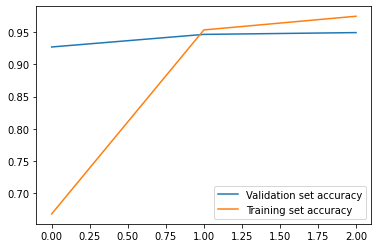

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt


def plot_history(history):
    train_metric = 'label_categorical_accuracy'
    val_metric = 'val_label_categorical_accuracy'
    plt.plot(history.history[val_metric],label="Validation set accuracy")
    plt.plot(history.history[train_metric],label="Training set accuracy")
    plt.legend()
    plt.show()


plot_history(history)

That's not a bad result.

## Predict with the trained model

Let's run a few simple cases through the trained model to illustrate its use.

In [30]:
def predict_tags(words):
    # This function takes a sequence of words, vectorizes it,
    # and returns the model predictions. The vectorization code
    # we wrote expects labels, so we'll attach dummy labels to
    # use the code and then discard the dummy labels it generates.
    dummy_tagged = [(word, NO_LABEL) for word in words]
    tokenized_test = tokenize_sentences([dummy_tagged])
    test_X, dummy_Y = vectorize_dataset(tokenized_test)
    # Run model.predict for this single sequence 
    predictions = model.predict(test_X)
    # Our outputs are one-hot, take argmax to get indices
    y = predictions[0].argmax(axis=1)
    # For words tokenized into several subword parts, we
    # only care about the predicted tag for the first part.
    # Use the tokenization to identify these parts.
    tags = []
    i = 1    # Start at 1 to skip the special [CLS] token.
    for tokens, _ in tokenized_test[0]:
        tags.append(int_to_tag[y[i]])
        i += len(tokens)
    return tags


# Test the model with a few word sequences
test_words = [
  'This model can predict parts of speech .'.split(),
  'What would the best time be tomorrow, John wondered quietly .'.split()
]


for words in test_words:
    tags = predict_tags(words)
    for w, t in zip(words, tags):
        print('{}\t{}'.format(w, t))
    print()

This	DET
model	NOUN
can	AUX
predict	VERB
parts	NOUN
of	ADP
speech	NOUN
.	PUNCT

What	PRON
would	AUX
the	DET
best	ADJ
time	NOUN
be	AUX
tomorrow,	NOUN
John	PROPN
wondered	VERB
quietly	ADV
.	PUNCT

